## Autoencoder

* 오토인코더는 간단한 비지도 학습 딥러닝 모형입니다. 입력을 압축한 후 다시 출력하는 모형입니다. 압축하는 과정에서 당연히 정보의 일부가 손실량을 최소한으로 유지하면서 전체 정보량을 유지하여 입력과 비슷한 값을 출력하도록 하는 것입니다. 일종의 Dimensionality Reduction 과정으로 해석할 수 있습니다.
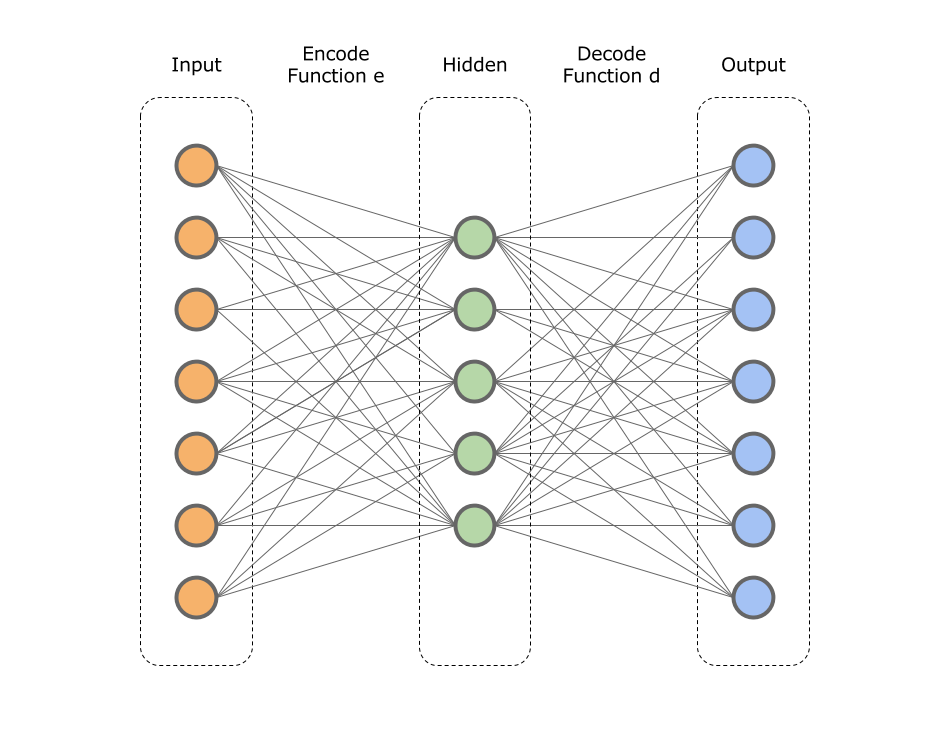

In [115]:
# MNIST
import numpy as np
from tensorflow import keras
from keras import models 
from keras import layers
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [116]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train=X_train/255
X_test=X_test/255

In [117]:
X_train = X_train.reshape(len(X_train), len(X_train[1])*len(X_train[1]))
X_test = X_test.reshape(len(X_test), len(X_test[1])*len(X_test[1]))

In [118]:
original_dim = 28 * 28
inter_dim = 64
latent_dim = 2

auto = models.Sequential()
auto.add(layers.Dense(inter_dim, activation='relu', input_shape=(28*28,))) 
auto.add(layers.Dense(original_dim, activation='sigmoid')) 
auto.compile(optimizer='nadam',loss='binary_crossentropy',metrics=['acc'])

In [119]:
auto.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_50 (Dense)             (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [120]:
auto.fit(X_train,X_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
375/375 [==============================] - 1s 2ms/step - loss: 0.2114 - acc: 0.0118 - val_loss: 0.1446 - val_acc: 0.0098
Epoch 2/5
375/375 [==============================] - 1s 2ms/step - loss: 0.1261 - acc: 0.0114 - val_loss: 0.1120 - val_acc: 0.0105
Epoch 3/5
375/375 [==============================] - 1s 2ms/step - loss: 0.1035 - acc: 0.0128 - val_loss: 0.0969 - val_acc: 0.0119
Epoch 4/5
375/375 [==============================] - 1s 2ms/step - loss: 0.0920 - acc: 0.0140 - val_loss: 0.0885 - val_acc: 0.0134
Epoch 5/5
375/375 [==============================] - 1s 2ms/step - loss: 0.0852 - acc: 0.0131 - val_loss: 0.0834 - val_acc: 0.0123


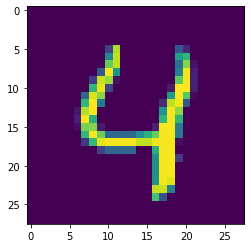

In [121]:
plt.imshow(X_test[4].reshape(28, 28))

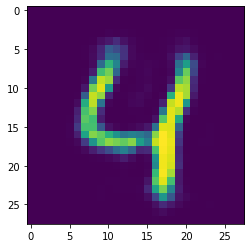

In [122]:
pre=auto.predict(X_test)
plt.imshow(pre[4].reshape(28, 28))

#### Funtional API

In [123]:
'''
auto = models.Sequential()
auto.add(layers.Dense(inter_dim, activation='relu', input_shape=(28*28,))) 
auto.add(layers.Dense(original_dim, activation='sigmoid')) 
auto.compile(optimizer='nadam',loss='binary_crossentropy',metrics=['acc'])
'''
original_dim = 28 * 28
inter_dim = 64
latent_dim = 2

input_layer = layers.Input(shape=(original_dim))
x = layers.Dense(inter_dim, activation='relu')(input_layer)
x = layers.Dense(inter_dim*2, activation='relu')(x)
output_layer = layers.Dense(original_dim, activation='sigmoid')(x)
net = models.Model(input_layer, output_layer)

In [124]:
net.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_52 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_53 (Dense)             (None, 784)               101136    
Total params: 159,696
Trainable params: 159,696
Non-trainable params: 0
_________________________________________________________________


In [125]:
net.compile(optimizer='nadam',loss='binary_crossentropy',metrics=['acc'])
net.fit(X_train,X_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
375/375 [==============================] - 1s 3ms/step - loss: 0.1893 - acc: 0.0122 - val_loss: 0.1300 - val_acc: 0.0098
Epoch 2/5
375/375 [==============================] - 1s 3ms/step - loss: 0.1168 - acc: 0.0111 - val_loss: 0.1088 - val_acc: 0.0113
Epoch 3/5
375/375 [==============================] - 1s 2ms/step - loss: 0.1013 - acc: 0.0121 - val_loss: 0.0967 - val_acc: 0.0106
Epoch 4/5
375/375 [==============================] - 1s 2ms/step - loss: 0.0938 - acc: 0.0117 - val_loss: 0.0911 - val_acc: 0.0121
Epoch 5/5
375/375 [==============================] - 1s 2ms/step - loss: 0.0893 - acc: 0.0126 - val_loss: 0.0871 - val_acc: 0.0136


## Variational Autoencoder

* Variational Autoencoder(변이 오토인코더)는 히든 레이어의 공간을 가우시안 분포로 변환합니다.

In [126]:
# data load
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = layers.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

In [127]:
# encoder
from keras import backend as K

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1)
    return z_mean + K.exp(0.5*z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var]) # Lambda: 레이어로 만들어주는 명령어

encoder=models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 64)           50240       input_15[0][0]                   
__________________________________________________________________________________________________
dense_55 (Dense)                (None, 2)            130         dense_54[0][0]                   
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 2)            130         dense_54[0][0]                   
____________________________________________________________________________________________

In [191]:
# decoder
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = models.Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2])
vae = models.Model(inputs, outputs) 

In [192]:
# vae
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = -0.5*(K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1))
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='nadam')

In [193]:
vae.fit(X_train,X_train,epochs=10,batch_size=128)

Epoch 1/100
469/469 [==============================] - 1s 2ms/step - loss: 220.8454
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 179.8038
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 173.4814
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 169.9507
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 167.7119
Epoch 6/100
469/469 [==============================] - 1s 2ms/step - loss: 166.0238
Epoch 7/100
469/469 [==============================] - 1s 2ms/step - loss: 164.5651
Epoch 8/100
469/469 [==============================] - 1s 2ms/step - loss: 163.1979
Epoch 9/100
469/469 [==============================] - 1s 2ms/step - loss: 162.0263
Epoch 10/100
469/469 [==============================] - 1s 2ms/step - loss: 161.0924
Epoch 11/100
469/469 [==============================] - 1s 2ms/step - loss: 160.3338
Epoch 12/100
469/469 [==============================] - 1s 2ms/step - loss

469/469 [==============================] - 1s 3ms/step - loss: 150.4818
Epoch 98/100
469/469 [==============================] - 1s 3ms/step - loss: 150.4444
Epoch 99/100
469/469 [==============================] - 1s 3ms/step - loss: 150.4172
Epoch 100/100
469/469 [==============================] - 1s 3ms/step - loss: 150.3727


vae_pre=vae.predict(X_test)
plt.imshow(vae_pre[1].reshape(28, 28))

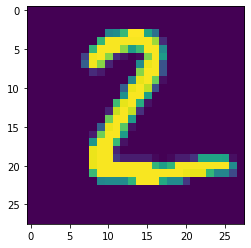

In [194]:
plt.imshow(X_test[1].reshape(28, 28))

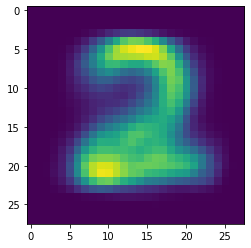

In [195]:
pre_vae=vae.predict(X_test)
plt.imshow(pre_vae[1].reshape(28,28))

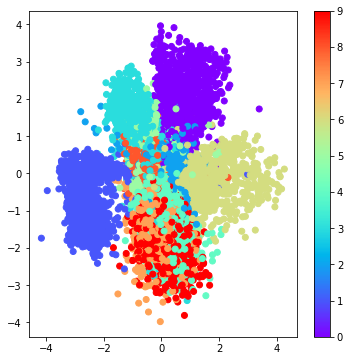

In [196]:
X_test_encoded = encoder.predict(X_test, batch_size=16)
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[0][:, 0], X_test_encoded[0][:, 1], c=y_test, cmap='rainbow')
plt.colorbar()
plt.show()


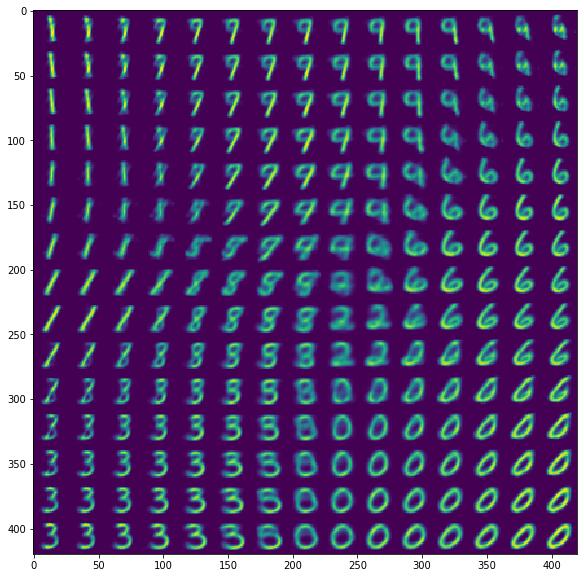

In [201]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
